In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz


In [2]:
build_ener_df = pd.read_feather("build_ener_df.ftr")
build_ener_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1503 non-null   int64  
 1   BuildingType                     1503 non-null   string 
 2   PrimaryPropertyType              1503 non-null   string 
 3   ZipCode                          1503 non-null   string 
 4   CouncilDistrictCode              1503 non-null   string 
 5   Neighborhood                     1503 non-null   string 
 6   Latitude                         1503 non-null   float64
 7   Longitude                        1503 non-null   float64
 8   YearBuilt                        1503 non-null   int64  
 9   NumberofBuildings                1503 non-null   int64  
 10  NumberofFloors                   1503 non-null   int64  
 11  PropertyGFATotal                 1503 non-null   int64  
 12  PropertyGFAParking  

In [3]:
# build_ener_df_enstr_drop = build_ener_df.copy()
build_ener_df_enstr_dflt = build_ener_df.copy()
build_ener_df_enstr_sub_imposs = build_ener_df.copy()
build_ener_df_enstr_oneht = build_ener_df.copy()
build_ener_df_enstr_intrp = build_ener_df.copy()
build_ener_df_no_enstr = build_ener_df.copy()

# build_ener_df_enstr_drop = build_ener_df_enstr_drop.loc[
#     ~build_ener_df_enstr_drop["ENERGYSTARScore"].isna()
# ].astype({"ENERGYSTARScore": "int"})
# build_ener_df_enstr_dflt["ENERGYSTARScore"] = (
#     build_ener_df_enstr_dflt["ENERGYSTARScore"]
#     .fillna(
#         int(
#             build_ener_df_enstr_drop.astype({"ENERGYSTARScore": int})[
#                 "ENERGYSTARScore"
#             ].median()
#         )
#     )
#     .astype({"ENERGYSTARScore": "int"})
# )
build_ener_df_enstr_dflt["ENERGYSTARScore"] = (
    build_ener_df_enstr_dflt["ENERGYSTARScore"]
    .fillna(
        int(
            build_ener_df.loc[~build_ener_df["ENERGYSTARScore"].isna()][
                "ENERGYSTARScore"
            ].median()
        )
    )
    .astype({"ENERGYSTARScore": "int"})
)
build_ener_df_enstr_sub_imposs["ENERGYSTARScore"] = (
    build_ener_df_enstr_sub_imposs["ENERGYSTARScore"]
    .fillna(-100)
    .astype({"ENERGYSTARScore": "int"})
)
build_ener_df_enstr_oneht = pd.concat(
    [
        build_ener_df_enstr_oneht,
        pd.get_dummies(
            build_ener_df_enstr_oneht.ENERGYSTARScore, prefix="ENERGYSTARScore"
        ),
    ],
    axis=1,
).drop("ENERGYSTARScore", axis=1)

build_ener_df_no_enstr = build_ener_df_no_enstr.drop("ENERGYSTARScore", axis=1)


In [4]:
imputation_df = build_ener_df_enstr_intrp.copy()

for col in ["PrimaryPropertyType", "LargestPropertyUseType"]:
    imputation_df = pd.concat(
        [
            imputation_df,
            pd.get_dummies(imputation_df[col], prefix=col),
        ],
        axis=1,
    ).drop(col, axis=1)

prop_type_cols = [
    x for x in imputation_df.columns.to_list() if x.startswith("PrimaryPropertyType")
]
prop_use_cols = [
    x for x in imputation_df.columns.to_list() if x.startswith("LargestPropertyUseType")
]
imput_cols = (
    [
        "Latitude",
        "Longitude",
        "YearBuilt",
        "PropertyGFATotal",
        "PropertyGFABuilding(s)",
        "LargestPropertyUseTypeGFA",
        "ENERGYSTARScore",
        "SiteEnergyUseWN(kBtu)",
        "SourceEnergyUseWN(kBtu)",
        "SteamUse(kBtu)",
        "Electricity(kBtu)",
        "NaturalGas(kBtu)",
        "TotalGHGEmissions",
    ]
    + prop_type_cols
    + prop_use_cols
)
it_imp = IterativeImputer(
    sample_posterior=True, min_value=1, max_value=100, random_state=0
)
build_ener_df_enstr_intrp["ENERGYSTARScore"] = (
    pd.DataFrame(it_imp.fit_transform(imputation_df[imput_cols]), columns=imput_cols)
    .round()
    .astype({"ENERGYSTARScore": "int"})["ENERGYSTARScore"]
    .to_list()
)

build_ener_df_enstr_intrp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1503 non-null   int64  
 1   BuildingType                     1503 non-null   string 
 2   PrimaryPropertyType              1503 non-null   string 
 3   ZipCode                          1503 non-null   string 
 4   CouncilDistrictCode              1503 non-null   string 
 5   Neighborhood                     1503 non-null   string 
 6   Latitude                         1503 non-null   float64
 7   Longitude                        1503 non-null   float64
 8   YearBuilt                        1503 non-null   int64  
 9   NumberofBuildings                1503 non-null   int64  
 10  NumberofFloors                   1503 non-null   int64  
 11  PropertyGFATotal                 1503 non-null   int64  
 12  PropertyGFAParking  

In [5]:
build_ener_dfs = {
    "ENERGYSTARScore NaNs replaced by median": build_ener_df_enstr_dflt,
    "ENERGYSTARScore NaNs replaced by negative scores": build_ener_df_enstr_sub_imposs,
    "ENERGYSTARScore NaNs imputed": build_ener_df_enstr_intrp,
    "ENERGYSTARScore with one-hot encoding": build_ener_df_enstr_oneht,
    "No ENERGYSTARScore used": build_ener_df_no_enstr,
}


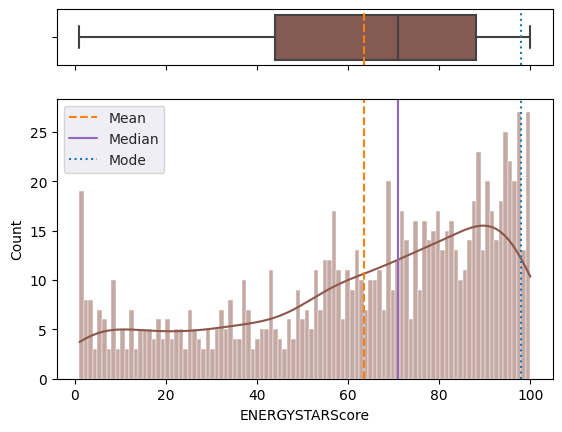

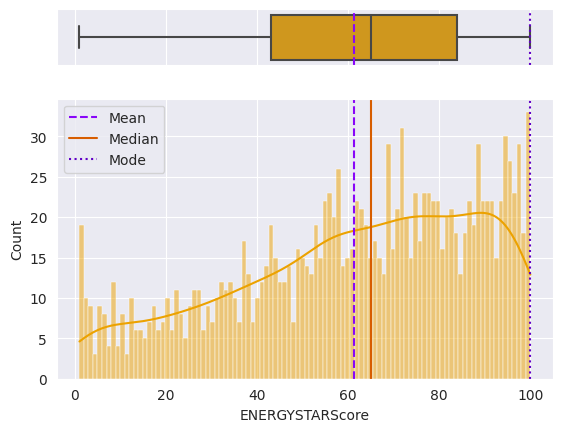

In [6]:
for df in [
    build_ener_df.loc[~build_ener_df["ENERGYSTARScore"].isna()].astype(
        {"ENERGYSTARScore": "int"}
    ),
    build_ener_df_enstr_intrp,
]:
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)}
    )
    mean = df["ENERGYSTARScore"].mean()
    median = df["ENERGYSTARScore"].median()
    mode = df["ENERGYSTARScore"].mode().values[0]
    theme_clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    sns.set_palette("gnuplot")
    sns.set_style("darkgrid")
    sns.boxplot(data=df, x="ENERGYSTARScore", ax=ax_box, color=theme_clrs[5])
    ax_box.axvline(mean, color=theme_clrs[1], linestyle="--")
    ax_box.axvline(mode, color=theme_clrs[0], linestyle=":")
    sns.histplot(
        data=df,
        x="ENERGYSTARScore",
        ax=ax_hist,
        bins=100,
        kde=True,
        color=theme_clrs[5],
    )
    ax_hist.axvline(mean, color=theme_clrs[1], linestyle="--", label="Mean")
    ax_hist.axvline(median, color=theme_clrs[4], linestyle="-", label="Median")
    ax_hist.axvline(mode, color=theme_clrs[0], linestyle=":", label="Mode")
    ax_hist.legend()
    ax_box.set(xlabel="")
    plt.show()


In [7]:
contin_feats = [
    "Latitude",
    "Longitude",
    "YearBuilt",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFATotal",
    "PropertyGFAParking",
    "PropertyGFABuilding(s)",
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA",
    "ENERGYSTARScore",
]
categ_feats = [
    "BuildingType",
    "PrimaryPropertyType",
    "ZipCode",
    "CouncilDistrictCode",
    "Neighborhood",
    "LargestPropertyUseType",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
]
mm_scaler = MinMaxScaler(feature_range=(0, 1))


def remove_unusable(df):
    for col_name in [
        x for x in df.columns.to_list() if x not in contin_feats + categ_feats
    ]:
        df = df.drop(col_name, axis=1)

    return df


def normalize_contin(df):
    cf_lst = [x for x in df.columns.to_list() if x in contin_feats]

    with pd.option_context("mode.chained_assignment", None):
        df[cf_lst] = mm_scaler.fit_transform(df[cf_lst].to_numpy())

    return df


def one_hot_categs(df):
    for col_name in [x for x in df.columns.to_list() if x in categ_feats]:
        df = pd.concat(
            [df, pd.get_dummies(df[col_name], prefix=col_name)], axis=1
        ).drop(col_name, axis=1)

    return df


def preproc_pipe(df):
    return df.copy().pipe(remove_unusable).pipe(normalize_contin).pipe(one_hot_categs)


In [8]:
def get_metrics(model, X, y):
    display(X)
    display(y)
    n = len(X)
    p = len(X.columns)
    r2 = cross_val_score(model, X=X, y=y, scoring="r2").mean()
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    rmse = abs(
        cross_val_score(model, X=X, y=y, scoring="neg_root_mean_squared_error").mean()
    )
    mae = abs(
        cross_val_score(model, X=X, y=y, scoring="neg_mean_absolute_error").mean()
    )

    return {
        "R^2": r2,
        "Adjusted R^2": r2_adj,
        "RMSE": rmse,
        "MAE": mae,
    }


target = build_ener_df["TotalGHGEmissions"]
dummy_metrics = {}

for build_ener_df_str in build_ener_dfs.keys():
    # X_train, X_test, y_train, y_test = train_test_split(
    #     build_ener_dfs[build_ener_df_str], target, test_size=0.2, random_state=0
    # )
    # dummy_y_pred = DummyRegressor().fit(X_train, y_train).predict(X_test)
    dummy_metrics[build_ener_df_str] = get_metrics(
        DummyRegressor(), preproc_pipe(build_ener_dfs[build_ener_df_str]), target
    )

display(dummy_metrics)


,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,...,ThirdLargestPropertyUseType_Refrigerated Warehouse,ThirdLargestPropertyUseType_Restaurant,ThirdLargestPropertyUseType_Retail Store,ThirdLargestPropertyUseType_Self-Storage Facility,ThirdLargestPropertyUseType_Social/Meeting Hall,ThirdLargestPropertyUseType_Strip Mall,ThirdLargestPropertyUseType_Supermarket/Grocery Store,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Vocational School,ThirdLargestPropertyUseType_Worship Facility
0,0.457508,0.492134,0.234783,0.009009,0.121212,0.008288,0.000000,0.009102,0.008887,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.461833,0.519197,0.834783,0.009009,0.111111,0.009913,0.029387,0.009109,0.008398,0.023540,...,0,1,0,0,0,0,0,0,0,0
2,0.465222,0.491401,0.600000,0.009009,0.414141,0.101497,0.383759,0.081120,0.080609,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.466069,0.501133,0.226087,0.009009,0.101010,0.005375,0.000000,0.006192,0.005976,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.464419,0.475603,0.695652,0.009009,0.181818,0.017649,0.120950,0.011801,0.012646,0.106276,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,0.138577,0.249367,0.713043,0.009009,0.010101,0.000749,0.000000,0.001570,0.001353,0.000000,...,0,0,0,0,0,0,0,0,0,0
1499,0.386392,0.593188,0.904348,0.009009,0.010101,0.000507,0.000000,0.001327,0.001111,0.000000,...,0,0,0,0,0,0,0,0,0,0
1500,0.565588,0.359819,0.643478,0.009009,0.010101,0.000201,0.000000,0.001022,0.000207,0.008710,...,0,0,0,0,0,0,0,1,0,0
1501,0.083512,0.583322,0.773913,0.009009,0.010101,0.000303,0.000000,0.001123,0.000101,0.010159,...,0,0,0,0,0,0,0,0,0,0


0        249.98
1        295.86
2       2089.28
3        286.43
4        505.01
         ...   
1498      20.33
1499      32.17
1500     223.54
1501      22.11
1502      41.27
Name: TotalGHGEmissions, Length: 1503, dtype: float64

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,...,ThirdLargestPropertyUseType_Refrigerated Warehouse,ThirdLargestPropertyUseType_Restaurant,ThirdLargestPropertyUseType_Retail Store,ThirdLargestPropertyUseType_Self-Storage Facility,ThirdLargestPropertyUseType_Social/Meeting Hall,ThirdLargestPropertyUseType_Strip Mall,ThirdLargestPropertyUseType_Supermarket/Grocery Store,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Vocational School,ThirdLargestPropertyUseType_Worship Facility
0,0.457508,0.492134,0.234783,0.009009,0.121212,0.008288,0.000000,0.009102,0.008887,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.461833,0.519197,0.834783,0.009009,0.111111,0.009913,0.029387,0.009109,0.008398,0.023540,...,0,1,0,0,0,0,0,0,0,0
2,0.465222,0.491401,0.600000,0.009009,0.414141,0.101497,0.383759,0.081120,0.080609,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.466069,0.501133,0.226087,0.009009,0.101010,0.005375,0.000000,0.006192,0.005976,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.464419,0.475603,0.695652,0.009009,0.181818,0.017649,0.120950,0.011801,0.012646,0.106276,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,0.138577,0.249367,0.713043,0.009009,0.010101,0.000749,0.000000,0.001570,0.001353,0.000000,...,0,0,0,0,0,0,0,0,0,0
1499,0.386392,0.593188,0.904348,0.009009,0.010101,0.000507,0.000000,0.001327,0.001111,0.000000,...,0,0,0,0,0,0,0,0,0,0
1500,0.565588,0.359819,0.643478,0.009009,0.010101,0.000201,0.000000,0.001022,0.000207,0.008710,...,0,0,0,0,0,0,0,1,0,0
1501,0.083512,0.583322,0.773913,0.009009,0.010101,0.000303,0.000000,0.001123,0.000101,0.010159,...,0,0,0,0,0,0,0,0,0,0


0        249.98
1        295.86
2       2089.28
3        286.43
4        505.01
         ...   
1498      20.33
1499      32.17
1500     223.54
1501      22.11
1502      41.27
Name: TotalGHGEmissions, Length: 1503, dtype: float64

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,...,ThirdLargestPropertyUseType_Refrigerated Warehouse,ThirdLargestPropertyUseType_Restaurant,ThirdLargestPropertyUseType_Retail Store,ThirdLargestPropertyUseType_Self-Storage Facility,ThirdLargestPropertyUseType_Social/Meeting Hall,ThirdLargestPropertyUseType_Strip Mall,ThirdLargestPropertyUseType_Supermarket/Grocery Store,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Vocational School,ThirdLargestPropertyUseType_Worship Facility
0,0.457508,0.492134,0.234783,0.009009,0.121212,0.008288,0.000000,0.009102,0.008887,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.461833,0.519197,0.834783,0.009009,0.111111,0.009913,0.029387,0.009109,0.008398,0.023540,...,0,1,0,0,0,0,0,0,0,0
2,0.465222,0.491401,0.600000,0.009009,0.414141,0.101497,0.383759,0.081120,0.080609,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.466069,0.501133,0.226087,0.009009,0.101010,0.005375,0.000000,0.006192,0.005976,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.464419,0.475603,0.695652,0.009009,0.181818,0.017649,0.120950,0.011801,0.012646,0.106276,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,0.138577,0.249367,0.713043,0.009009,0.010101,0.000749,0.000000,0.001570,0.001353,0.000000,...,0,0,0,0,0,0,0,0,0,0
1499,0.386392,0.593188,0.904348,0.009009,0.010101,0.000507,0.000000,0.001327,0.001111,0.000000,...,0,0,0,0,0,0,0,0,0,0
1500,0.565588,0.359819,0.643478,0.009009,0.010101,0.000201,0.000000,0.001022,0.000207,0.008710,...,0,0,0,0,0,0,0,1,0,0
1501,0.083512,0.583322,0.773913,0.009009,0.010101,0.000303,0.000000,0.001123,0.000101,0.010159,...,0,0,0,0,0,0,0,0,0,0


0        249.98
1        295.86
2       2089.28
3        286.43
4        505.01
         ...   
1498      20.33
1499      32.17
1500     223.54
1501      22.11
1502      41.27
Name: TotalGHGEmissions, Length: 1503, dtype: float64

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,...,ThirdLargestPropertyUseType_Refrigerated Warehouse,ThirdLargestPropertyUseType_Restaurant,ThirdLargestPropertyUseType_Retail Store,ThirdLargestPropertyUseType_Self-Storage Facility,ThirdLargestPropertyUseType_Social/Meeting Hall,ThirdLargestPropertyUseType_Strip Mall,ThirdLargestPropertyUseType_Supermarket/Grocery Store,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Vocational School,ThirdLargestPropertyUseType_Worship Facility
0,0.457508,0.492134,0.234783,0.009009,0.121212,0.008288,0.000000,0.009102,0.008887,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.461833,0.519197,0.834783,0.009009,0.111111,0.009913,0.029387,0.009109,0.008398,0.023540,...,0,1,0,0,0,0,0,0,0,0
2,0.465222,0.491401,0.600000,0.009009,0.414141,0.101497,0.383759,0.081120,0.080609,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.466069,0.501133,0.226087,0.009009,0.101010,0.005375,0.000000,0.006192,0.005976,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.464419,0.475603,0.695652,0.009009,0.181818,0.017649,0.120950,0.011801,0.012646,0.106276,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,0.138577,0.249367,0.713043,0.009009,0.010101,0.000749,0.000000,0.001570,0.001353,0.000000,...,0,0,0,0,0,0,0,0,0,0
1499,0.386392,0.593188,0.904348,0.009009,0.010101,0.000507,0.000000,0.001327,0.001111,0.000000,...,0,0,0,0,0,0,0,0,0,0
1500,0.565588,0.359819,0.643478,0.009009,0.010101,0.000201,0.000000,0.001022,0.000207,0.008710,...,0,0,0,0,0,0,0,1,0,0
1501,0.083512,0.583322,0.773913,0.009009,0.010101,0.000303,0.000000,0.001123,0.000101,0.010159,...,0,0,0,0,0,0,0,0,0,0


0        249.98
1        295.86
2       2089.28
3        286.43
4        505.01
         ...   
1498      20.33
1499      32.17
1500     223.54
1501      22.11
1502      41.27
Name: TotalGHGEmissions, Length: 1503, dtype: float64

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,...,ThirdLargestPropertyUseType_Refrigerated Warehouse,ThirdLargestPropertyUseType_Restaurant,ThirdLargestPropertyUseType_Retail Store,ThirdLargestPropertyUseType_Self-Storage Facility,ThirdLargestPropertyUseType_Social/Meeting Hall,ThirdLargestPropertyUseType_Strip Mall,ThirdLargestPropertyUseType_Supermarket/Grocery Store,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Vocational School,ThirdLargestPropertyUseType_Worship Facility
0,0.457508,0.492134,0.234783,0.009009,0.121212,0.008288,0.000000,0.009102,0.008887,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.461833,0.519197,0.834783,0.009009,0.111111,0.009913,0.029387,0.009109,0.008398,0.023540,...,0,1,0,0,0,0,0,0,0,0
2,0.465222,0.491401,0.600000,0.009009,0.414141,0.101497,0.383759,0.081120,0.080609,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.466069,0.501133,0.226087,0.009009,0.101010,0.005375,0.000000,0.006192,0.005976,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.464419,0.475603,0.695652,0.009009,0.181818,0.017649,0.120950,0.011801,0.012646,0.106276,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,0.138577,0.249367,0.713043,0.009009,0.010101,0.000749,0.000000,0.001570,0.001353,0.000000,...,0,0,0,0,0,0,0,0,0,0
1499,0.386392,0.593188,0.904348,0.009009,0.010101,0.000507,0.000000,0.001327,0.001111,0.000000,...,0,0,0,0,0,0,0,0,0,0
1500,0.565588,0.359819,0.643478,0.009009,0.010101,0.000201,0.000000,0.001022,0.000207,0.008710,...,0,0,0,0,0,0,0,1,0,0
1501,0.083512,0.583322,0.773913,0.009009,0.010101,0.000303,0.000000,0.001123,0.000101,0.010159,...,0,0,0,0,0,0,0,0,0,0


0        249.98
1        295.86
2       2089.28
3        286.43
4        505.01
         ...   
1498      20.33
1499      32.17
1500     223.54
1501      22.11
1502      41.27
Name: TotalGHGEmissions, Length: 1503, dtype: float64

{'ENERGYSTARScore NaNs replaced by median': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore NaNs replaced by negative scores': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore NaNs imputed': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore with one-hot encoding': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.3570770199122062,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'No ENERGYSTARScore used': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.3570770199122062,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662}}

In [9]:
def get_support_feats(estimator, X, y):
    rfecv = RFECV(estimator=estimator, scoring="r2")

    rfecv.fit(X, y)

    return list(X.columns[rfecv.support_])


In [10]:
support_feats = get_support_feats(LinearRegression(), preproc_pipe(build_ener_df_enstr_dflt), target)

display(dummy_metrics)
display(support_feats)
display(get_metrics(LinearRegression(), preproc_pipe(build_ener_df_enstr_dflt)[support_feats], target))


{'ENERGYSTARScore NaNs replaced by median': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore NaNs replaced by negative scores': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore NaNs imputed': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore with one-hot encoding': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.3570770199122062,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'No ENERGYSTARScore used': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.3570770199122062,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662}}

['PrimaryPropertyType_K-12 School',
 'PrimaryPropertyType_Self-Storage Facility',
 'PrimaryPropertyType_Worship Facility',
 'LargestPropertyUseType_K-12 School',
 'LargestPropertyUseType_Worship Facility']

,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Worship Facility,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Worship Facility
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
1498,0,0,0,0,0
1499,0,0,0,0,0
1500,0,0,0,0,0
1501,0,0,0,0,0


0        249.98
1        295.86
2       2089.28
3        286.43
4        505.01
         ...   
1498      20.33
1499      32.17
1500     223.54
1501      22.11
1502      41.27
Name: TotalGHGEmissions, Length: 1503, dtype: float64

{'R^2': -0.14649565396991648,
 'Adjusted R^2': -0.15032496477141932,
 'RMSE': 700.2869480356843,
 'MAE': 244.85567647691005}

In [11]:
rfe = RFE(estimator=LinearRegression())
gd_sr = GridSearchCV(estimator=rfe, param_grid={"n_features_to_select": list(range(1, 31))}, scoring="r2", cv=5, n_jobs=1)
df1 = preproc_pipe(build_ener_df_enstr_dflt)


gd_sr.fit(df1, target)
print(gd_sr.best_params_)

KeyboardInterrupt: 

In [62]:
mm_scaler = MinMaxScaler(feature_range=(0, 1))


def normalize_contin(df, contin_feats, scale_enstr=False):
    feats = contin_feats.copy()

    if scale_enstr:
        feats += ["ENERGYSTARScore"]

    with pd.option_context("mode.chained_assignment", None):
        df[feats] = mm_scaler.fit_transform(df[feats].to_numpy())

    return df


def one_hot_categs(df, categ_feats):
    for feat in categ_feats:
        df = pd.concat(
            [
                df,
                pd.get_dummies(df[feat], prefix=feat),
            ],
            axis=1,
        ).drop(feat, axis=1)

    return df


# string, explanatory df, target
def make_ret_sub_arr(string, df, contin_feats, categ_feats, enstr=False):
    return [
        string,
        normalize_contin(
            one_hot_categs(
                df[
                    contin_feats + categ_feats + (["ENERGYSTARScore"] if enstr else [])
                ].copy(),
                categ_feats,
            ),
            contin_feats,
            scale_enstr=enstr,
        ),
        df["TotalGHGEmissions"].copy(),
    ]


def proc_data_and_targ(contin_feats, categ_feats):
    return [
        make_ret_sub_arr(
            "ENERGYSTARScore NaNs dropped",
            build_ener_df_enstr_drop,
            contin_feats,
            categ_feats,
            enstr=True,
        ),
        make_ret_sub_arr(
            "ENERGYSTARScore NaNs replaced by median",
            build_ener_df_enstr_dflt,
            contin_feats,
            categ_feats,
            enstr=True,
        ),
        make_ret_sub_arr(
            "ENERGYSTARScore NaNs replaced by negative scores",
            build_ener_df_enstr_sub_imposs,
            contin_feats,
            categ_feats,
            enstr=True,
        ),
        make_ret_sub_arr(
            "ENERGYSTARScore NaNs imputed",
            build_ener_df_enstr_intrp,
            contin_feats,
            categ_feats,
            enstr=True,
        ),
        make_ret_sub_arr(
            "ENERGYSTARScore with one-hot encoding",
            build_ener_df_enstr_oneht,
            contin_feats,
            categ_feats,
            enstr=False,
        ),
        make_ret_sub_arr(
            "No ENERGYSTARScore used",
            build_ener_df_no_enstr,
            contin_feats,
            categ_feats,
            enstr=False,
        ),
    ]


In [63]:
cont_feats = [
    "YearBuilt",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFATotal",
    "PropertyGFAParking",
    "PropertyGFABuilding(s)",
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA",
]

print('Correlation coefficients to "TotalGHGEmissions":')

for feat in cont_feats:
    print(f"\"{feat}\": {build_ener_df[feat].corr(build_ener_df['TotalGHGEmissions'])}")


Correlation coefficients to "TotalGHGEmissions":
"YearBuilt": 0.05331227372782265
"NumberofBuildings": 0.4191292839258652
"NumberofFloors": 0.1271608993148391
"PropertyGFATotal": 0.5277744664277798
"PropertyGFAParking": 0.05383349340289043
"PropertyGFABuilding(s)": 0.5441175515476439
"LargestPropertyUseTypeGFA": 0.5749223198758678
"SecondLargestPropertyUseTypeGFA": 0.43830120966952724
"ThirdLargestPropertyUseTypeGFA": 0.3922096336788742


In [64]:
data_and_targets = proc_data_and_targ(
    [
        # "Latitude",
        # "Longitude",
        "YearBuilt",
        "NumberofBuildings",
        # "NumberofFloors",
        "PropertyGFATotal",
        # "PropertyGFAParking",
        "PropertyGFABuilding(s)",
        "LargestPropertyUseTypeGFA",
        # "SecondLargestPropertyUseTypeGFA",
        # "ThirdLargestPropertyUseTypeGFA",
    ],
    [
        # "BuildingType",
        "PrimaryPropertyType",
        # "ZipCode",
        # "CouncilDistrictCode",
        # "Neighborhood",
        "LargestPropertyUseType",
        # "SecondLargestPropertyUseType",
        # "ThirdLargestPropertyUseType",
    ],
)
runs = 200
test_size = 0.2
cv_folds = 5
first_run = True
best_metrics = {}
dummy_metrics = {}

for datum_and_target in data_and_targets:
    # RMSE, R^2, model
    best_metrics[datum_and_target[0]] = [np.inf, 0, LinearRegression()]

for i in range(0, runs):
    for datum_and_target in data_and_targets:
        X_train, X_test, y_train, y_test = train_test_split(
            datum_and_target[1],
            datum_and_target[2],
            test_size=test_size,
        )
        regr_model = LinearRegression()
        metrics = cross_validate(
            regr_model,
            X_train,
            y_train,
            cv=cv_folds,
            scoring=["neg_root_mean_squared_error", "r2"],
        )
        rmse = -1 * metrics["test_neg_root_mean_squared_error"].mean()
        r2 = metrics["test_r2"].mean()

        if rmse < best_metrics[datum_and_target[0]][0]:
            regr_model.fit(X_train, y_train)
            y_pred = regr_model.predict(X_test)
            best_metrics[datum_and_target[0]] = [
                mean_squared_error(y_test, y_pred, squared=False),
                r2_score(y_test, y_pred),
                regr_model,
            ]

        if first_run:
            dummy_y_pred = DummyRegressor().fit(X_train, y_train).predict(X_test)
            dummy_r2 = r2_score(y_test, dummy_y_pred)
            dummy_metrics[datum_and_target[0]] = [
                mean_squared_error(y_test, dummy_y_pred, squared=False),
                dummy_r2,
            ]

    first_run = False

ghg_desc_es_na_drp = build_ener_df_enstr_drop.describe()["TotalGHGEmissions"]
ghg_desc_rest = build_ener_df.describe()["TotalGHGEmissions"]
ghg_stats_es_na_drp = (
    f"TotalGHGEmissions - mean: {round(ghg_desc_es_na_drp['mean'], 4)}, "
    + f"std. dev.: {round(ghg_desc_es_na_drp['std'], 4)}"
)
ghg_stats_rest = (
    f"TotalGHGEmissions - mean: {round(ghg_desc_rest['mean'], 4)}, "
    + f"std. dev.: {round(ghg_desc_rest['std'], 4)}"
)

print(f"Best metrics ({runs} iterations, {test_size * 100}% test size)\n")

for datum_and_target in data_and_targets:
    arr = best_metrics[datum_and_target[0]]
    dummy_arr = dummy_metrics[datum_and_target[0]]

    print(
        f"{datum_and_target[0]}\n"
        + f"{ghg_stats_es_na_drp if datum_and_target[0] == 'ENERGYSTARScore NaNs dropped' else ghg_stats_rest}\n"
        + f"\tDummy RMSE:\t\t{round(dummy_arr[0], 4)} kg CO2/sq. ft.\n"
        + f"\tRMSE:\t\t\t{round(arr[0], 4)} kg CO2/sq. ft.\n\tDummy R^2:\t\t{round(dummy_arr[1], 4)}\n"
        + f"\tR^2:\t\t\t{round(arr[1], 4)}"
    )


Best metrics (200 iterations, 20.0% test size)

ENERGYSTARScore NaNs dropped
TotalGHGEmissions - mean: 197.8652, std. dev.: 873.7209
	Dummy RMSE:		1256.4087 kg CO2/sq. ft.
	RMSE:			345.5744 kg CO2/sq. ft.
	Dummy R^2:		-0.0038
	R^2:			0.5601
ENERGYSTARScore NaNs replaced by median
TotalGHGEmissions - mean: 196.7726, std. dev.: 790.2903
	Dummy RMSE:		674.5652 kg CO2/sq. ft.
	RMSE:			1799504485157.0527 kg CO2/sq. ft.
	Dummy R^2:		-0.0036
	R^2:			-7.14226425499006e+18
ENERGYSTARScore NaNs replaced by negative scores
TotalGHGEmissions - mean: 196.7726, std. dev.: 790.2903
	Dummy RMSE:		834.5783 kg CO2/sq. ft.
	RMSE:			29100675566280.63 kg CO2/sq. ft.
	Dummy R^2:		-0.0001
	R^2:			-4.3691005708036913e+21
ENERGYSTARScore NaNs imputed
TotalGHGEmissions - mean: 196.7726, std. dev.: 790.2903
	Dummy RMSE:		229.175 kg CO2/sq. ft.
	RMSE:			46876991530628.305 kg CO2/sq. ft.
	Dummy R^2:		-0.1646
	R^2:			-2.1143162254832857e+22
ENERGYSTARScore with one-hot encoding
TotalGHGEmissions - mean: 196.7726, s

In [72]:
feats = [
    "Latitude",
    "Longitude",
    "YearBuilt",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFATotal",
    "PropertyGFAParking",
    "PropertyGFABuilding(s)",
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA",
    "BuildingType",
    "PrimaryPropertyType",
    "ZipCode",
    "CouncilDistrictCode",
    "Neighborhood",
    "LargestPropertyUseType",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
    "TotalGHGEmissions",
]
categ_feats = [
    "BuildingType",
    "PrimaryPropertyType",
    "ZipCode",
    "CouncilDistrictCode",
    "Neighborhood",
    "LargestPropertyUseType",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
]
dt_dfs = {
    "ENERGYSTARScore NaNs dropped": build_ener_df_enstr_drop,
    "ENERGYSTARScore NaNs replaced by median": build_ener_df_enstr_dflt,
    "ENERGYSTARScore NaNs replaced by negative scores": build_ener_df_enstr_sub_imposs,
    "ENERGYSTARScore NaNs imputed": build_ener_df_enstr_intrp,
    "ENERGYSTARScore with one-hot encoding": build_ener_df_enstr_oneht,
    "No ENERGYSTARScore used": build_ener_df_no_enstr,
}
runs = 100
test_size = 0.2
cv_folds = 5
best_rmse = {}

for dt_df_str in dt_dfs.keys():
    best_rmse[dt_df_str] = [np.inf, None, None, None]
    dt_dfs[dt_df_str] = dt_dfs[dt_df_str].copy()[
        feats
        + (
            ["ENERGYSTARScore"]
            if dt_df_str
            not in ["No ENERGYSTARScore used", "ENERGYSTARScore with one-hot encoding"]
            else []
        )
    ]
    dt_dfs[dt_df_str] = one_hot_categs(dt_dfs[dt_df_str], categ_feats=categ_feats)

for i in range(0, runs):
    for dt_df_str in dt_dfs.keys():
        dt_reg_modl = DecisionTreeRegressor(random_state=0)
        X_train, X_test, y_train, y_test = train_test_split(
            dt_dfs[dt_df_str].drop(["TotalGHGEmissions"], axis=1),
            dt_dfs[dt_df_str]["TotalGHGEmissions"],
            test_size=test_size,
        )
        metrics = cross_validate(
            dt_reg_modl,
            X_train,
            y_train,
            cv=cv_folds,
            scoring=["neg_root_mean_squared_error", "r2"],
        )
        rmse = -1 * metrics["test_neg_root_mean_squared_error"].mean()

        if rmse < best_rmse[dt_df_str][0]:
            best_rmse[dt_df_str] = [rmse, X_test, y_test, dt_reg_modl.fit(X_train, y_train)]

for dt_df_str in dt_dfs.keys():
    y_pred = best_rmse[dt_df_str][3].predict(best_rmse[dt_df_str][1])
    rmse = mean_squared_error(best_rmse[dt_df_str][2], y_pred, squared=False)
    r2 = r2_score(best_rmse[dt_df_str][2], y_pred)
    print(
        f"{dt_df_str}\n\tDummy RMSE:\t{dummy_metrics[dt_df_str][0]}\n\tRMSE:\t\t{rmse}\n"
        + f"\tDummy R^2:\t{dummy_metrics[dt_df_str][1]}\n\tR^2:\t\t{r2}"
    )


ENERGYSTARScore NaNs dropped
	Dummy RMSE:	1256.4087341364548
	RMSE:		1273.7311813730798
	Dummy R^2:	-0.0037989845180785853
	R^2:		0.3438291255527173
ENERGYSTARScore NaNs replaced by median
	Dummy RMSE:	674.565156998571
	RMSE:		1299.469604175391
	Dummy R^2:	-0.0036397594469634864
	R^2:		0.30078880122233587
ENERGYSTARScore NaNs replaced by negative scores
	Dummy RMSE:	834.5783250787002
	RMSE:		1086.4355801981992
	Dummy R^2:	-7.858239939384504e-05
	R^2:		0.22558817977121737
ENERGYSTARScore NaNs imputed
	Dummy RMSE:	229.17499270209723
	RMSE:		931.0119079185005
	Dummy R^2:	-0.16464165661340635
	R^2:		0.5392163047546543
ENERGYSTARScore with one-hot encoding
	Dummy RMSE:	1453.2111424784978
	RMSE:		1222.5300802441063
	Dummy R^2:	-0.012005306302686813
	R^2:		0.18477456897481437
No ENERGYSTARScore used
	Dummy RMSE:	819.1798169571532
	RMSE:		1179.4996779884048
	Dummy R^2:	-0.00017254900361707293
	R^2:		0.2419906677701632
